### IMPLEMENTACION DE UNA RED CONVOLUCIONAL EN PYTHON  

crear una red convolucional para clasificacion de imagenes usandop tensorflow  

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

* luego se carga la base de datos, enm este ejemplo usaremos mnist que consiste en 70000 imagenes en escala de grises de 10 digitos escritos a mano
* Tensorflow tiene una funcion para descargar de manera que entrega los datos de entrenamiento y test ya separados

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


* al imprimir el tamañao de los dos set de datos corresponden a 60000 datos de entrenamiento y 10000 de test, todas de 28x28 pixeles

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

* Se procede a graficar la distribucion de las clases para los datos de entrenamiento y test.
* Se observa que a pesar de que los datos no estan completamente balanceados, la proporcion de las clases es similar.

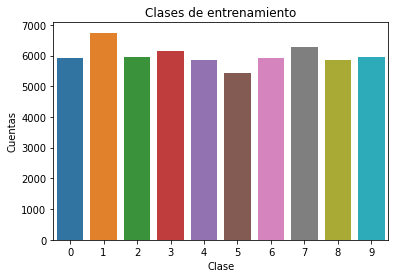

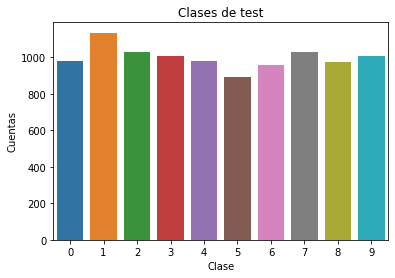

In [4]:
sns.countplot(y_train)
plt.xlabel('Clase')
plt.ylabel('Cuentas')
plt.title('Clases de entrenamiento')
plt.show()
sns.countplot(y_test)
plt.xlabel('Clase')
plt.ylabel('Cuentas')
plt.title('Clases de test')
plt.show()


* Los datos vienen en escala de grises, cada pixel toma valores numericos de 0 a 255.
* La imagen corresponde a un 0 como caracter descrito anteriormente.

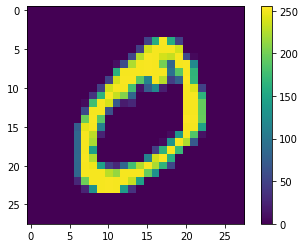

In [5]:
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

* Para poder ser usados por la red, deben ser normalizados, en este caso cada pixel debera tener valores entre 0 y 1.
* Se realiza dividiendo las imagenes por 255, se realiza la misma operacion en el set de test.

In [6]:
x_train = x_train/255
x_test = x_test/255

* La forma se mantiene, pero la figura indica que el maximo es uno y el minimo es 0.

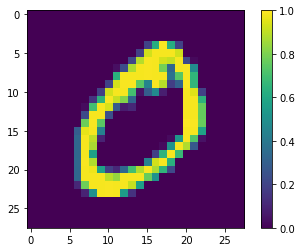

In [7]:
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

* Se preprocesan las etiquetas, que deben ser transformadas a forma vectorial, en este caso (ONEHOT)
* Como argumento pasamos "sparse = False" para que el formato de salida de los datos sea el adecuado.

In [8]:
encoder = OneHotEncoder(sparse=False)


* Ademas se deba cambiar la forma mediante "reshape" ya que el encoder solo acepta vectores columna.
* Se pasa de tener un vector fila de etiquetas a un vector columna.

In [9]:
print('Forma inicial: ', y_train.shape)
y_train = y_train.reshape(-1,1)
print('Forma en columna: ', y_train.shape)

Forma inicial:  (60000,)
Forma en columna:  (60000, 1)


* Transformamos las etiquetas de entretanimento, la forma final de las etiquetas son de 60000 filas, una por cada ejemplo y 10 columnas, 1 por cada clase

In [10]:
y_train = encoder.fit_transform(y_train)
print('Forma final: ', y_train.shape)


Forma final:  (60000, 10)


* Se agrega una dimension al final de las imagenes para representar el canal, en blanco y negro es 1, si las imagenes fueran en colores tendrian 3 canales.

In [11]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

* Las redes neuronales deben usar un set de validacion durante el entrenamiento, apra evaluar la convergencia del modelo.
* Usaremos el 10% del set de entrenamiento como validacion.
* La separacion sera estratificada, para manetener la proporcion entre las clases

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, train_size=0.9, stratify=y_train)

* Con los datos preprocesados se procede a construir la red, tensorflow permite construir redes de diferentes maneras, dependiendo del nivel de control que se requiera.

  + El sequential, permite crear modelos de forma sencilla, pero esta limitado a operaciones mas comunes, es ideal para crear prototipos de forma rapida.
 
  + con mas complejidad esta el Functional que da mas control sobre los procesos, pero al mismo tiempo requiere poner atencion a detalles que el formalismo secuencial automatiza.

  +  El Subclasses, que da control maximo del proceso, es ideal cuando se reuqiere implementar una funcional especifica que no esta la galeria por defecto.

* en la primera linea inicializa el modelo, las siguientes agregan las capas.

  + La primera capa es convolucional y contiene 32 filtros de 3 x 3 pixels, con funcion de activacion "ReLu", al ser la primera capa definimos la forma del imput, que es de 28 x 28 y 1 canal.

  + Se agrega "DownSampling", en este caso MaxPooling de 3 x 3 pixeles.

  + Expresamos el resultado de esta capa como un vector, al aplanarlo con la capa "Flatten".
  
  + La ultima capa es de salida, que proyecta a la cantidad total de clases, en este caso 10, la funcion de activacion es "SoftMax", que permite obtener probabilidad de salida para cada clase.

In [13]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)) )
model.add(tf.keras.layers.MaxPooling2D((3, 3)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(10,activation='softmax'))

* Se compila, definiendo la funcion de perdida y el optimizador.

  + La funcion de perdida es "CrossEntropy" y el optimizador sera "Adam".
  
  + Ademas de la funcion de perdida se usara la metrica "Accuracy", para monitorear el comportamiento general del clasificador.

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

* Una vez compilado se puede ver un resumen del modelo, para cada capa nos indica cuantos paramentros son entrenables y los tamaños de entrada y salida.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,810
Trainable params: 20,810
Non-trainable params: 0
_________________________________________________________________


* Lo siguiente es entrenar el modelo, para ello usamos la funcion "fit".

* Definimos la cantidad de "epochs" o epocas que corresponde a la cantidad de veces que el modelo va a iterar sobre los datos, mientras mas epocas mayor sera el ajuste, pero demasiadas pueden sobreajustar el modelo.

* El "batch_size", es la cantidad de elementos con los que la red va a entreanr en un paso, mientras mayor sea su tamaño mas rapido sera el entrenamiento, pero introduce menos aleatoriedad en el proceso y consumira mas recursos por paso.

* Se entregan ademas los datos de entrenamiento:

  + x es la entrada, en este caso las imagenes.

  + y es la salida, en este caso la clase de cada imagen.
  
  + adicionalmente entregamos los datos de validacion x_val e y_val, estos valores nos permiten monitorear el proceso de entrenamiento en un set de datos independiente.

* Las estadisticas de entrenamiento, junto con la metrica son almacenadas en la variable history.

* Mientras el modelo esta entrenando, se pueden ver las estadisticas en la salida del notebook, se observa que la funcion de perdida dismuye en cada epoca y el accuracy aumenta.

In [16]:
epochs = 5
batch_size = 5000

history = model.fit(x=x_train, 
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))

Epoch 1/5
11/11 [==============================] - 4s 376ms/step - loss: 2.1726 - accuracy: 0.3985 - val_loss: 1.9738 - val_accuracy: 0.6348
Epoch 2/5
11/11 [==============================] - 4s 377ms/step - loss: 1.7787 - accuracy: 0.7111 - val_loss: 1.5146 - val_accuracy: 0.7653
Epoch 3/5
11/11 [==============================] - 4s 382ms/step - loss: 1.2979 - accuracy: 0.7821 - val_loss: 1.0481 - val_accuracy: 0.7880
Epoch 4/5
11/11 [==============================] - 4s 376ms/step - loss: 0.8924 - accuracy: 0.8087 - val_loss: 0.7370 - val_accuracy: 0.8222
Epoch 5/5
11/11 [==============================] - 4s 378ms/step - loss: 0.6490 - accuracy: 0.8393 - val_loss: 0.5696 - val_accuracy: 0.8497


* Se visualiza los valores de la funcion de perdida para el entrenamiento y validacion

* Se observa que tanto para el entrenamiento como para la validacion, la funcion de perdida dismuye mas rapido en los datos de entrenamiento y no tanto en los de validacion, esto es normal ya que la red esta entrenada en estos datos.

* Cuando la funcion de perdida empieza a aumentar en el set de validacion, sabremos que el modelo se empezo a sobreajustar.

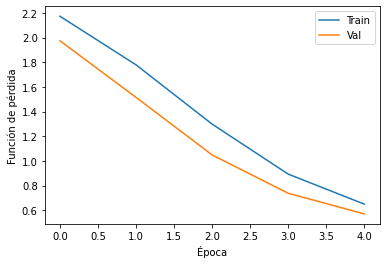

In [17]:
plt.plot(np.arange(epochs), history.history['loss'], label='Train')
plt.plot(np.arange(epochs), history.history['val_loss'], label='Val')
plt.legend(loc=0)
plt.xlabel('Época')
plt.ylabel('Función de pérdida')
plt.show()

* Graficamos los valores de accuracy, que es un valor mas interpretable del rendimeinto del clasificador

* Se observa que el rendimeinto es mayor que el 80%, si estamos conformes podemos realizar una prediccion en el set de test.

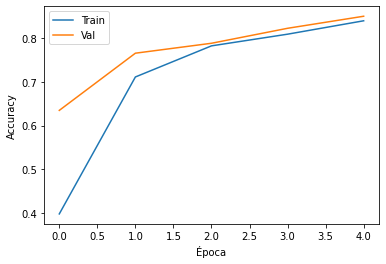

In [18]:
plt.plot(np.arange(epochs), history.history['accuracy'], label='Train')
plt.plot(np.arange(epochs), history.history['val_accuracy'], label='Val')
plt.legend(loc=0)
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.show()

* Se transforma los valores a float32, para evitar warnings de TensorFlow

In [19]:
y_pred = model(x_test.astype(np.float32))

* Para obtener una prediccion, debemos obtener la clase con mayor probabilidad, esto se realiza con "argmax" en axis=1, es decir, buscamos en mayor entre las columnas.

In [20]:
y_pred = y_pred.numpy().argmax(axis=1)

* Se procede a graficar la matriz de confusion, elejimos normalize=True.

* el modelo es muy efectivo en la tarea, si se hubiera seguido entrenando se podria obtener un mejor resultado se puede probar cambiando la cantidad de epocas o el batch_size.

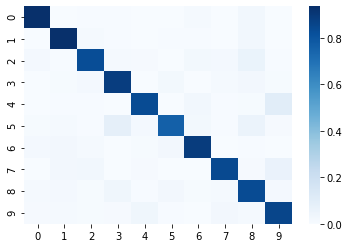

In [21]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, cmap='Blues');